# Lecture 7. Word Embeddings and Document Embeddings

# Setup

In [2]:
import warnings; warnings.simplefilter('ignore')
# set this to your working directory
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)
df = df[pd.notnull(df['authorship'])] # drop cases without an author
import numpy as np
vocab = pd.read_pickle('vec-3grams-1.pkl')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [6]:
vocab

CountVectorizer(max_df=0.9, max_features=1000, min_df=0.01, ngram_range=(1, 3),
                stop_words='english')

In [3]:
df.head()

,case_name,opinion_type,date_standard,authorship,x_republican,maj_judges,dissent_judges,topic_id,cite_count,opinion_text,year,log_cite_count,author_id
0,ERICK CORNELL CLAY v. UNITED STATES,majority,2003-03-04,GINSBURG,0.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,2926.0,JUSTICE GINSBURG delivered the opinion of the ...,2003,7.981392,2
1,"HILLSIDE DAIRY INC., A&A DAIRY, L&S DAIRY, AND...",majority,2003-06-09,STEVENS,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['THOMAS, CLARENCE']",8.0,117.0,Justice Stevens delivered the opinion of the C...,2003,4.762174,9
2,"CHARLES RUSSELL RHINES v. DOUGLAS WEBER, WARDEN",majority,2005-03-30,O'CONNOR,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,23364.0,Justice O'Connor delivered the opinion of the ...,2005,10.058952,4
3,STATE OF ALASKA v. UNITED STATES OF AMERICA,majority,2005-06-06,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['REHNQUIST, WILLIAM', 'SCALIA, ANTONIN', 'THO...",10.0,84.0,Justice Kennedy delivered the opinion of the C...,2005,4.430817,3
4,"REGINALD A. WILKINSON, DIRECTOR, OHIO DEPARTME...",majority,2005-06-13,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],4.0,4230.0,Justice Kennedy delivered the opinion of the C...,2005,8.349957,3


# Word2Vec in gensim

In [8]:
# word2vec requires sentences as input
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               vector_size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([ 3.50044272e-03,  1.09471276e-01,  1.89118460e-02,  2.98242108e-03,
        2.23855637e-02, -5.02593592e-02, -8.41846988e-02, -5.41015752e-02,
       -2.97277626e-02, -6.53750300e-02,  7.01329708e-02, -1.51487984e-04,
        5.35362847e-02, -8.85581747e-02,  4.47229296e-02, -2.06466392e-02,
        8.17348585e-02, -1.11580100e-02, -7.71727338e-02,  4.47031334e-02,
        9.51520801e-02, -5.08819297e-02,  4.12083380e-02, -5.11239022e-02,
       -1.19550526e-01,  1.09554669e-02, -4.34614951e-03,  3.14397458e-03,
        8.57475549e-02,  1.24724843e-01,  4.77274321e-02,  2.76030842e-02,
       -3.27122794e-03,  6.97744042e-02, -1.89012922e-02,  6.29672781e-02,
        5.16591109e-02, -2.10677925e-02, -1.63317714e-02,  1.43735874e-02,
        9.00672302e-02,  2.47636661e-02, -1.98068805e-02, -3.23316827e-02,
       -3.11542358e-02, -5.27771302e-02,  1.27558829e-02,  5.79995336e-04,
       -7.01681823e-02, -3.08874398e-02,  4.21950407e-02, -5.57770766e-02,
       -3.68882045e-02, -

In [9]:
w2v.wv.similarity('judg','juri') # similarity 

0.51561445

In [10]:
w2v.wv.most_similar('judg') # most similar words

[('bench', 0.5770953297615051),
 ('speedi', 0.5591809749603271),
 ('court', 0.5264284014701843),
 ('juri', 0.5156144499778748),
 ('factfind', 0.5078095197677612),
 ('panel', 0.503343403339386),
 ('alj', 0.4931626319885254),
 ('erron', 0.4929620623588562),
 ('imparti', 0.4903097450733185),
 ('magistr', 0.48937076330184937)]

In [12]:
# word2vec requires sentences as input
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower#.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words ]#if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               vector_size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([-2.91491821e-02,  9.85957496e-03, -1.10921701e-02,  6.83232620e-02,
        2.25688051e-02,  1.25564843e-01, -1.24336250e-01, -7.21174404e-02,
        1.66288037e-02,  6.27120808e-02,  6.56858161e-02, -8.09567645e-02,
       -3.80402319e-02,  1.80611778e-02, -2.56777871e-02,  1.13503048e-02,
        5.08099608e-02, -5.48825115e-02, -6.47601038e-02,  5.59769273e-02,
        1.25459675e-02,  1.13309763e-01,  2.29970664e-02,  1.55565087e-02,
        1.19692177e-01,  4.56537120e-02, -1.52575979e-02,  1.15730078e-03,
        6.73862770e-02,  3.92369069e-02, -2.57511437e-03,  8.27853158e-02,
        1.74762420e-02,  2.77706571e-02, -4.71317843e-02,  1.08926237e-01,
        7.66637325e-02,  2.86472794e-02, -3.25980783e-02, -8.44625607e-02,
       -1.09473743e-01, -2.78722774e-02,  7.02197403e-02,  6.82300329e-02,
       -3.39206383e-02,  3.14291194e-02,  5.79600371e-02,  1.69720603e-04,
       -7.04447478e-02, -8.86106305e-03, -4.41748127e-02,  1.03224106e-02,
        8.59129652e-02,  

In [13]:
w2v.wv.similarity('judg','juri') # similarity 

0.66157424

In [14]:
w2v.wv.most_similar('judg') # most similar words

[('judge,', 0.8000794649124146),
 ('juri', 0.6615741848945618),
 ('judge.', 0.6142669320106506),
 ('jury,', 0.5905029773712158),
 ('magistr', 0.5817164182662964),
 ('court', 0.5718361139297485),
 ('prosecutor', 0.539625883102417),
 ('panel', 0.5297359228134155),
 ('jury.', 0.5296885967254639),
 ('court,', 0.5275548696517944)]

In [15]:
# analogies: judge is to man as __ is to woman
w2v.wv.most_similar(positive=['judg','man'],
                 negative=['woman'])

[('judge,', 0.7108926773071289),
 ('juri', 0.5796605348587036),
 ('jury,', 0.5446411371231079),
 ('prosecutor', 0.5223242044448853),
 ('magistr', 0.5093206763267517),
 ('judges,', 0.47275310754776),
 ('court', 0.45911210775375366),
 ('juror', 0.45653295516967773),
 ('judge.', 0.45480430126190186),
 ('court,', 0.4494791328907013)]

In [ ]:
# Word2Vec: K-Means Clusters
from sklearn.cluster import KMeans
kmw = KMeans(n_clusters=50)
kmw.fit(w2v.wv.vectors)
judge_clust = kmw.labels_[w2v.wv.vocab['judg'].index]
for i, cluster in enumerate(kmw.labels_):
    if cluster == judge_clust and i<=100:
        print(w2v.wv.index2word[i])

# Pre-trained vectors

In [17]:
import spacy
en = spacy.load('en_core_web_sm')
apple = en('apple') 
apple.vector # vector for 'apple'

array([-1.1682467 , -0.37714803,  0.12145093,  0.45870188,  0.18772878,
       -0.19632639, -0.6110377 , -0.4902766 , -0.49642107,  0.03152977,
        0.0023616 ,  0.2951656 ,  0.77547336,  1.2774839 , -0.43516952,
        0.620906  ,  0.5234567 , -0.65061796,  0.09567964, -0.10973874,
       -1.040125  , -0.03391492,  0.7943465 ,  0.5763587 , -0.33247274,
        0.6273351 , -0.5002353 , -1.2046773 ,  0.08557288, -0.72076684,
        0.99808097, -1.4318945 , -0.24133801, -0.9739387 ,  0.26214337,
       -1.707262  , -0.44079256, -0.0782887 , -0.86503595,  0.9095436 ,
       -0.51132363, -1.0881265 , -0.07267377,  0.37482548, -0.71514815,
       -0.7081649 ,  0.2249467 , -0.09205632,  2.038834  ,  1.6421666 ,
        0.13038152,  0.87407124, -0.3831597 , -0.55295014, -0.4367904 ,
        0.5167299 , -0.9234768 , -0.0098993 ,  0.7303829 , -0.57531416,
       -0.78162503, -0.07682188,  0.28484625, -0.4955305 ,  0.2101677 ,
       -0.05586254, -0.9700649 ,  0.0505102 , -0.15979525, -0.17

In [18]:
apple.similarity(apple)

1.0

In [19]:
orange = en('orange')
apple.similarity(orange)

0.6120262928222482

In [24]:
import spacy
# !python -m spacy download de_core_news_sm
de = spacy.load('de_core_news_sm')
apfel = de('apfel')
orange = de('orange')
apfel.similarity(orange)

0.5679784026232193

In [ ]:
# Initializing an embedding layer with pre-trained vectors
embed_dims = len(apple.vector)
embedding_matrix = np.zeros([num_words, embed_dims])
for word, i in tokenizer.word_index.items():
    if i > num_words:
        break
    embedding_vector = en(word).vector
    embedding_matrix[i-1] = embedding_vector    

In [ ]:
model = Sequential()
model.add(Embedding(num_words,
                    embed_dims,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False)) # frozen layer
model.add(Flatten()) # 86*300 = 25800 dims
model.add(Dense(64,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# show the vectors
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)

df3 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(3):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)
    
    word_vectors = model.layers[0].get_weights()[0]
    wv_tsne = tsne.fit_transform(word_vectors)

    df3['x'] = wv_tsne[:,0]
    df3['y'] = wv_tsne[:,1]
    plot = sns.relplot( data=df3, x="x", y="y", s=0, height=8.27, aspect=11.7/8.27)

    for row in df3.itertuples():
        ax = plot.axes[0, 0]
        ax.text(row.x, row.y, row.word, horizontalalignment='left')
    plt.show()

# GloVe

In [ ]:
!pip install glove-python-binary 
#!pip install glove_python for other versions

import itertools
from glove import Corpus, Glove

from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

corpus = Corpus()
corpus.fit(sentences, window=10)
glove = Glove(no_components=100, learning_rate=0.05)

In [28]:
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [29]:
glove.word_vectors[glove.dictionary['judg']]

array([-0.08653001, -0.17560872, -0.08418459,  0.32607356,  0.39523273,
        0.40038577,  0.51838954,  0.35508087,  0.19994376, -0.36647405,
        0.14755011, -0.2294461 ,  0.38933591,  0.11395296,  0.0811669 ,
        0.36121975, -0.51663723, -0.32205669, -0.47055161,  0.15814387,
       -0.3579082 ,  0.13087014,  0.77570509, -0.57549655, -0.3317956 ,
        0.17665669, -0.21040899, -0.21396896,  0.58286689, -0.15201207,
        0.02330768,  0.27287893,  0.21180193,  0.3419429 , -0.11861553,
        0.03327698, -0.20617868, -0.03837308,  0.14021797,  0.35076086,
        0.24876995, -0.67752256, -0.19577163, -0.2587846 , -0.29165091,
       -0.15233416, -0.0597882 , -0.09168504,  0.34418621, -0.35259037,
       -0.06409723, -0.02555829,  0.07709359,  0.04971176,  0.32340396,
        0.54846501,  0.00559629,  0.26360828,  0.332366  ,  0.22523595,
        0.22771294, -0.28317422,  0.24293435,  0.06115823, -0.27244096,
       -0.46946138,  0.08042832,  0.36742124,  0.1402191 ,  0.59

In [30]:
glove.most_similar('judg')

[('magistr', 0.8393923896288058),
 ('dawson', 0.7476459305806409),
 ('couvillion', 0.6975637504746839),
 ('trial', 0.6816014591155274)]


# Word Mover Distance

In [31]:
!pip install wmd

  Using cached wmd-1.3.2.tar.gz (104 kB)
  Created wheel for wmd: filename=wmd-1.3.2-cp38-cp38-linux_x86_64.whl size=1246228 sha256=86998fe6b1a724cae68252332697a74f41aa46603c3140ff4c2afe0c0fc1cdfe
  Stored in directory: /root/.cache/pip/wheels/eb/4c/cd/40ec1e13bfd149162c9a69f5b07728410ea9af264e66cea28d
Successfully built wmd


In [32]:
import spacy
import wmd
nlp = spacy.load('en_core_web_sm', 
                 create_pipeline=wmd.WMD.create_spacy_pipeline)
doc1 = nlp("Politician speaks to the media in Illinois.")
doc2 = nlp("The president greets the press in Chicago.")
print(doc1.similarity(doc2))

TypeError: load() got an unexpected keyword argument 'create_pipeline'

# **Document Embeddings**

In [34]:
###
# Setup
###
import numpy as np
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')

import spacy
nlp = spacy.load('en_core_web_sm')

# word2vec requires sentences as input
sentences = []
for doc in df1['snippet']:
    sents = [sent for sent in nlp(doc).sents]
    sentences += sents
#     sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

In [35]:
df1

,court_id,author_id,state,year,dateFiled,citeCount,snippet
0,nj,NaN,NJ,1965,1965-09-14T00:00:00Z,8,N.J. ( )\n A. d \nIN RE WAIVER OF DEATH PE...
1,fla,4019.0,FL,1973,1973-07-26T00:00:00Z,552,"whether the death penalty is, per se, unconsti..."
2,texcrimapp,5765.0,TX,1975,1975-04-16T00:00:00Z,143,# ;s contention that the assessment of the dea...
3,nm,NaN,NM,2009,2009-11-30T00:00:00Z,0,. d ( )\n -NMSC- \nIN THE MATTER OF DEATH PE...
4,texcrimapp,5758.0,TX,1944,1944-12-20T00:00:00Z,56,assume the district attorney orally waived the...
...,...,...,...,...,...,...,...
32562,ohioctapp,8055.0,OH,2017,2017-07-20T00:00:00Z,0,of two counts of aggravated murder with deat...
32563,cal,NaN,CA,2017,2017-07-20T00:00:00Z,0,his general views about the death penalty as ...
32564,neb,NaN,NE,2017,2017-07-21T00:00:00Z,0,"been subject to the death\npenalty, because Ne..."
32565,ohio,5374.0,OH,2017,2017-07-25T00:00:00Z,0,that Indiana law permits imposition of the de...


**Average word2vec Embeddings**

In [36]:
###
# Make document vectors by averaging word embeddings in a document
##

# Continuous bag-of-words representation
from gensim.models import Word2Vec
w2v = Word2Vec.load('w2v-vectors.pkl')

sentvecs = []
for sentence in sentences:
    vecs = [w2v.wv[w.text] for w in sentence if w.text in w2v.wv]
    if len(vecs)== 0:
        sentvecs.append(np.nan)
        continue
    sentvec = np.mean(vecs,axis=0)
    sentvecs.append(sentvec.reshape(1,-1))
sentvecs[0][0][:30]

array([ 0.04322254,  0.00378752,  0.00022201,  0.04447641,  0.03993042,
        0.02517693, -0.06413621, -0.03878698,  0.01721041, -0.01198456,
       -0.00474415, -0.00582627,  0.03736865,  0.02312173, -0.04012159,
        0.0415687 , -0.02698223,  0.00657411, -0.02088499,  0.01820669,
        0.02379147, -0.00259077,  0.00384387,  0.03344381,  0.02849121,
       -0.00038616,  0.04330245,  0.03534286,  0.00727678,  0.0355307 ],
      dtype=float32)

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(sentvecs[0],
                  sentvecs[1])[0][0]

0.8318952

**Doc2Vec**

In [38]:
###
# Doc2Vec
###

from nltk import word_tokenize
docs = []

for i, row in df1.iterrows():
    docs += [word_tokenize(row['snippet'])]
shuffle(docs)

In [39]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
doc_iterator = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
d2v = Doc2Vec(doc_iterator,
                min_count=10, # minimum word count
                window=10,    # window size
                vector_size=100, # size of document vector
                sample=1e-4, 
                negative=5, 
                workers=4, # threads
                #dbow_words = 1 # uncomment to get word vectors too
                max_vocab_size=1000) # max vocab size

In [40]:
d2v.save('d2v-vectors.pkl')

In [ ]:
# matrix of all document vectors:
D = d2v.docvecs.vectors_docs
D.shape

In [ ]:
D

In [42]:
# infer vectors for new documents
a = d2v.infer_vector(['the judge on the court'])

b = d2v.infer_vector(['the jury and the judge'])

c = d2v.infer_vector(['cats hunt mice'])

In [43]:
a.shape, b.shape
print(cosine_similarity(np.expand_dims(a, axis=0), np.expand_dims(b, axis=0)))
print(cosine_similarity(np.expand_dims(a, axis=0), np.expand_dims(c, axis=0)))


[[-0.06581009]]
[[-0.01951269]]


In [ ]:
# get all pair-wise document similarities
pairwise_sims = cosine_similarity(D)
pairwise_sims.shape

In [78]:
pairwise_sims[:3,:3]

array([[1.        , 0.9648808 , 0.9575009 ],
       [0.9648808 , 1.        , 0.94865024],
       [0.9575009 , 0.94865024, 1.0000005 ]], dtype=float32)

In [79]:
# Document clusters
from sklearn.cluster import KMeans

# create 50 clusters of similar documents
num_clusters = 50
kmw = KMeans(n_clusters=num_clusters)
kmw.fit(D)

KMeans(n_clusters=50)

In [80]:
# Documents from an example cluster
for i, doc in enumerate(docs):
    if kmw.labels_[i] == 25:
        print(' '.join(doc[:9]))
    if i == 1000:
        break

Ill.Dec . , N.E . d . In cases
a part of the record in cases in which
enactment of the Antiterrorism and Effective Death Penalty Act
understood the Commonwealth is seeking the death penalty which
jurisdiction upon the Appellate Court. & quot ; Even
chapter provided , except in those cases where the
Public Acts of as imposes a mandatory death penalty
paragraph one of the syllabus , vacated as to
Supreme Court held that a defendant facing the death
series of statutory sections relating to the death penalty
; state [ was ] involved in [ the
signed into law the Antiterrorism and Effective Death Penalty
felonies less than capital in a case in which
LE d ) , has held that the imposition
) , Ill. d , N.E . d (
gratuitous statement of preference for the death penalty does
enactment of the Anti-terrorism and Effective Death Penalty Act
for mental retardation and imposition of the death penalty
as to whether or not to seek the death
Henderson v. State , supra . Our review of
The arguments as to 

In [ ]:
# t-SNE for visualization
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
# d2v_tsne = tsne.fit_transform(D)

In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(D)
pca.explained_variance_ratio_

array([0.77038383, 0.06582018, 0.03675219], dtype=float32)

In [ ]:
#vdf = pd.DataFrame(Xpca,
#                  columns=['x-tsne', 'y-tsne'])
#vdf['cluster'] = kmw.labels_

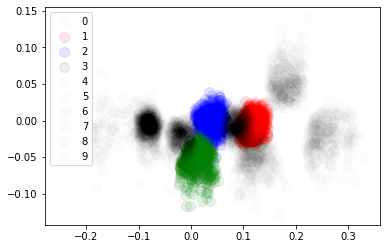

In [82]:
#%% PCA Viz
import matplotlib.pyplot as plt

#plt.scatter(Xpca[:,0],Xpca[:,1], alpha=.1)

cdict = {1: 'red', 2: 'blue', 3: 'green'}
fig, ax = plt.subplots()
#for g, label in cdict.items():
for g in np.unique(kmw.labels_):
    ix = np.where(kmw.labels_ == g)
    #ix = np.where(kmw == g)
    #    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
    if g in cdict:
        # use color from cdict
        color = cdict[g]
        ax.scatter(Xpca[:,0][ix], Xpca[:,1][ix], c = color, label = g, s = 100, alpha=0.1)
    else:
        if g < 10:
            color = "black"
            ax.scatter(Xpca[:,0][ix], Xpca[:,1][ix], c = color, label = g, s = 100, alpha=0.01)
    

        
ax.legend()
plt.show()

In [ ]:
# sample 100 texts to show different document embeddings techniques

texts = df1["snippet"][:100]
text = texts[0]
text, texts

**Other types of Document Embeddings**

In [83]:
# spacy embeddings (= averaged gloVe embeddings)

import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp(text)
doc.vector

array([ 0.04008213,  0.0177352 ,  0.15708926, -0.0859902 ,  0.08302165,
       -0.1916263 , -0.42941216,  0.08636231,  0.1072958 ,  0.09222322,
        0.03945342, -0.11509437, -0.02390743, -0.04594674,  0.3165045 ,
        0.17403561, -0.09391474, -0.04491444,  0.215745  ,  0.1403297 ,
        0.00071583, -0.2215382 ,  0.23657532,  0.21325368,  0.00507971,
       -0.17327744, -0.2302382 , -0.48890978,  0.243143  , -0.26164663,
        0.12965454, -0.2646581 ,  0.42853937, -0.02864659,  0.2591034 ,
       -0.279786  , -0.02469642,  0.10324604,  0.0250174 ,  0.01916229,
       -0.3460816 , -0.09573887,  0.38573962, -0.05293633, -0.12193681,
       -0.05869852,  0.06743139, -0.24440847,  0.18216322,  0.04186251,
       -0.07164774,  0.03959379,  0.15969723, -0.00188436,  0.14734301,
       -0.01418862, -0.13632214,  0.02214633,  0.16401884, -0.10532392,
       -0.3264483 , -0.06745633, -0.13638985, -0.11525523, -0.10350735,
       -0.06082028,  0.01643252,  0.01267994, -0.03538121, -0.45

**Uinversal Sentence Encoder**

In [ ]:
# universal sentence encoder
!pip install --upgrade tensorflow-hub

In [85]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import tensorflow_hub as hub
import numpy as np

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

embeddings = embed([text])

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    text_encoded = session.run(embeddings)



module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


2022-04-11 00:03:13.207909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-11 00:03:13.207939: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-11 00:03:13.421144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-11 00:03:14.162974: W tensorflow/core/common_runtime/colocation_graph.cc:1203] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:l

In [86]:
text_encoded

array([[-5.75881787e-02, -4.48678993e-02, -5.97575605e-02,
        -9.60366335e-03,  4.87336107e-02, -7.14330003e-02,
         5.63876238e-03, -4.17736471e-02,  6.94411173e-02,
        -7.18879700e-02,  4.38294373e-02,  4.96255197e-02,
         2.92646624e-02,  5.06394245e-02,  5.02831191e-02,
        -5.43750636e-02,  1.20516934e-05,  3.34072635e-02,
        -2.29961034e-02,  5.17977625e-02,  1.33965574e-02,
         2.34781709e-02,  6.57833889e-02, -2.41349824e-02,
        -5.89741282e-02,  4.48849648e-02,  8.91339593e-03,
        -1.31372558e-02, -5.10082208e-02,  8.32207967e-03,
         3.43775637e-02, -6.50016367e-02,  3.18927504e-02,
        -5.33328839e-02, -6.16215952e-02, -6.11270331e-02,
        -4.20963466e-02,  1.39375580e-02,  6.44143624e-03,
         6.65995479e-02, -3.60511541e-02, -1.41065773e-02,
        -7.03564053e-03, -4.17812392e-02, -4.14931811e-02,
         5.47353178e-02,  2.42106803e-02, -6.66408911e-02,
        -3.75429988e-02, -5.52068166e-02, -5.62858656e-0

**SBERT**

In [ ]:
!pip install sentence-transformers

In [88]:
from sentence_transformers import SentenceTransformer
model = "bert-base-nli-mean-tokens"
embedder = SentenceTransformer(model)
text_encoded = embedder.encode([text])

In [89]:
text_encoded

array([[-4.94830877e-01, -3.07748497e-01,  2.38643706e-01,
        -1.12242088e-01,  3.68263185e-01, -2.13435516e-01,
         8.10863554e-01, -2.53932953e-01,  8.49518254e-02,
         4.34113666e-02, -5.31976391e-03,  4.72682863e-01,
         9.99898016e-02,  4.15400296e-01, -1.31251180e+00,
         4.92496580e-01,  1.40618965e-01, -3.23016405e-01,
         1.41713113e-01, -3.53501767e-01,  4.34755124e-02,
        -7.69813284e-02,  2.29930565e-01,  5.27145088e-01,
         9.18621957e-01,  6.17869377e-01, -5.80663979e-01,
         2.21835390e-01, -7.82553732e-01,  5.84526539e-01,
        -1.58552885e-01,  2.56739974e-01, -1.15312052e+00,
         5.24774147e-03,  6.55010790e-02,  5.42442918e-01,
         1.94232747e-01, -1.94006234e-01,  2.46752918e-01,
         1.75805941e-01, -6.84098899e-01,  1.05391644e-01,
        -3.26745480e-01, -2.70014167e-01, -1.21031687e-01,
        -4.18343127e-01,  1.40245140e+00,  4.35338885e-01,
         9.15403128e-01, -1.82648510e-01,  3.20812970e-0